In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from functions import load_data, replace_missing_long, widen_data, feature_engineering, normalize_data, remove_outliers, group_data, remove_incorrect_values, replace_missing_wide

In [2]:
data = load_data()
data = remove_incorrect_values(data)

### Task 1B: Data cleaning

In [3]:
data = replace_missing_long(data)

In [4]:
# transform the data to wide format
data = widen_data(data)

data

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17 12:04:42.394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-17 18:28:25.520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-18 09:29:51.257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,AS14.01,2014-02-19 14:43:30.575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,AS14.01,2014-02-19 17:29:10.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358917,AS14.33,2014-05-30 22:32:05.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358918,AS14.33,2014-05-30 22:32:11.049,NaN,3.122,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358919,AS14.33,2014-05-30 22:32:14.240,NaN,1.003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358920,AS14.33,2014-05-30 22:32:15.246,NaN,4.134,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
activity,22965.0,0.115958,0.186946,0.000,0.00000,0.021739,0.158333,1.000
appCat.builtin,91285.0,19.446411,312.914956,0.001,2.02000,4.038000,9.922000,33960.246
appCat.communication,74276.0,43.343792,128.912750,0.006,5.21800,16.225500,45.475750,9830.777
appCat.entertainment,27124.0,37.577866,262.965225,0.001,1.33400,3.391500,14.922250,32148.677
appCat.finance,939.0,21.755251,39.218361,0.131,4.07200,8.026000,20.155000,355.513
appCat.game,813.0,128.391615,327.145246,1.003,14.14800,43.168000,123.625000,5491.793
appCat.office,5642.0,22.578892,449.601382,0.003,2.00400,3.106000,8.043750,32708.818
appCat.other,7650.0,25.810839,112.781355,0.014,7.01900,10.028000,16.829250,3892.038
appCat.social,19145.0,72.401906,261.551846,0.094,9.03000,28.466000,75.372000,30000.906


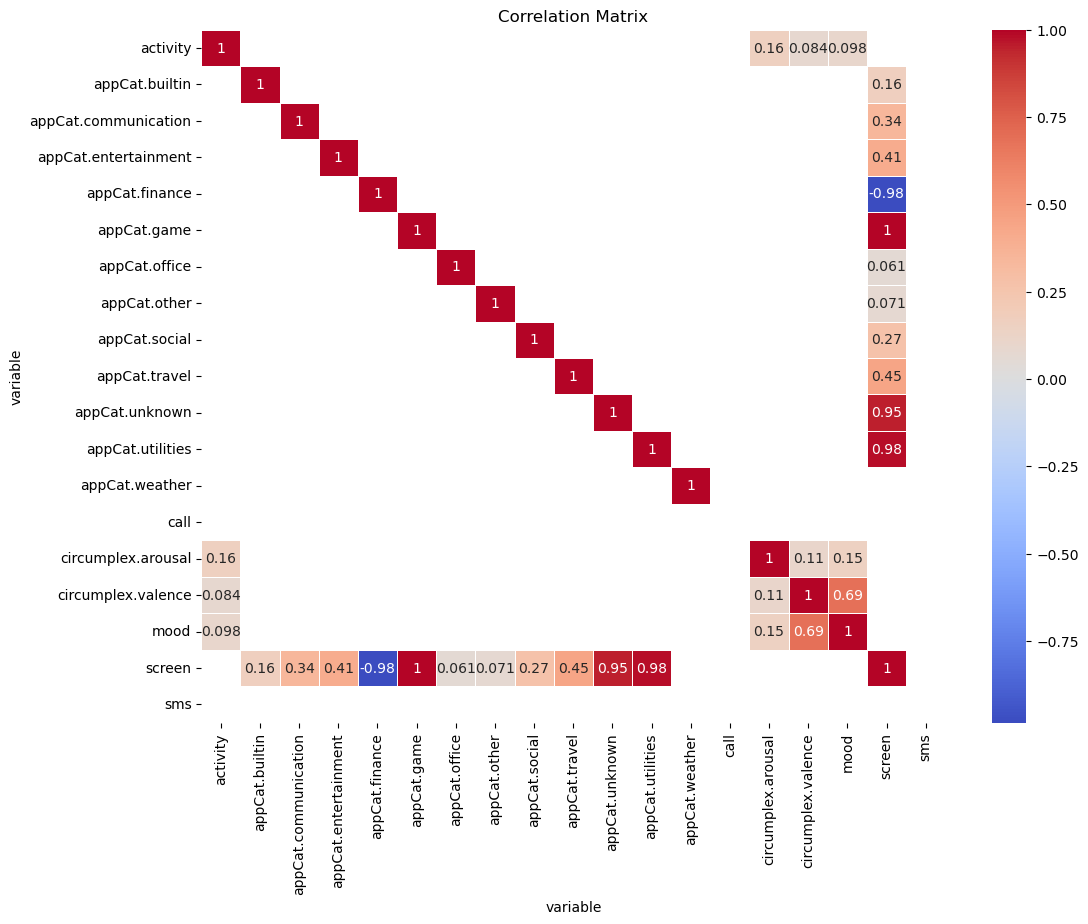

In [6]:
corr = data.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [7]:
# sum variables
sum_vars = ['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 
                 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 
                 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 
                 'appCat.weather', 'screen', 'call', 'sms']
# mean variables
mean_vars = ['circumplex.arousal', 'circumplex.valence', 'activity', 'mood']

# group the wide data by day and id and aggregate the sum and mean of the variables
grouped_wide = group_data(data)
grouped_wide

variable,time,id,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,2014-02-17,AS14.01,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,1.000000,NaN,NaN,NaN,0.000000,0.000000
1,2014-02-17,AS14.02,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.666667,NaN,NaN,NaN,0.000000,0.333333
2,2014-02-17,AS14.03,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,1.000000
3,2014-02-17,AS14.06,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,1.000000,NaN,NaN,NaN,0.000000,0.000000
4,2014-02-17,AS14.08,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,2014-06-05,AS14.24,0.152343,6.454897,3.538085,0.0,0.0,0.0,0.0,0.174760,...,0.832978,0.0,0.000000,0.0,0.040590,-0.017316,0.949057,7.0,8.751251,0.000000
1969,2014-06-06,AS14.24,0.189476,3.261717,5.899738,0.0,0.0,0.0,0.0,0.125566,...,0.000000,0.0,0.007145,0.0,0.055172,0.500000,0.808962,7.5,9.425283,0.000000
1970,2014-06-07,AS14.24,0.081893,36.169050,5.294712,0.0,0.0,0.0,0.0,0.044705,...,0.000000,0.0,0.000000,0.0,0.000000,-1.000000,0.745283,8.0,39.786892,0.014388
1971,2014-06-08,AS14.24,0.079510,10.648152,11.379242,0.0,0.0,0.0,0.0,0.547545,...,0.000000,0.0,0.000000,0.0,0.000000,-1.500000,1.000000,6.5,34.278727,0.000000


In [16]:
# select one day
day = grouped_wide[grouped_wide['time'] == '2014-06-09']
day

variable,time,id,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
1972,2014-06-09,AS14.24,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0


In [8]:
# show rows with missing values
grouped_wide[grouped_wide.isnull().any(axis=1)]

variable,time,id,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,2014-02-17,AS14.01,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,1.000000,NaN,NaN,NaN,0.000000,0.000000
1,2014-02-17,AS14.02,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.666667,NaN,NaN,NaN,0.000000,0.333333
2,2014-02-17,AS14.03,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,1.000000
3,2014-02-17,AS14.06,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,1.000000,NaN,NaN,NaN,0.000000,0.000000
4,2014-02-17,AS14.08,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,2014-05-15,AS14.31,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.5,1.0,7.0,0.000000,0.000000
1921,2014-05-17,AS14.31,0.026727,0.445143,7.072071,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.552357,0.0,0.000000,NaN,NaN,NaN,11.834571,0.000000
1960,2014-05-30,AS14.26,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,-0.4,0.0,6.4,0.000000,0.000000
1963,2014-05-31,AS14.33,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,-2.0,1.0,7.0,0.000000,0.000000


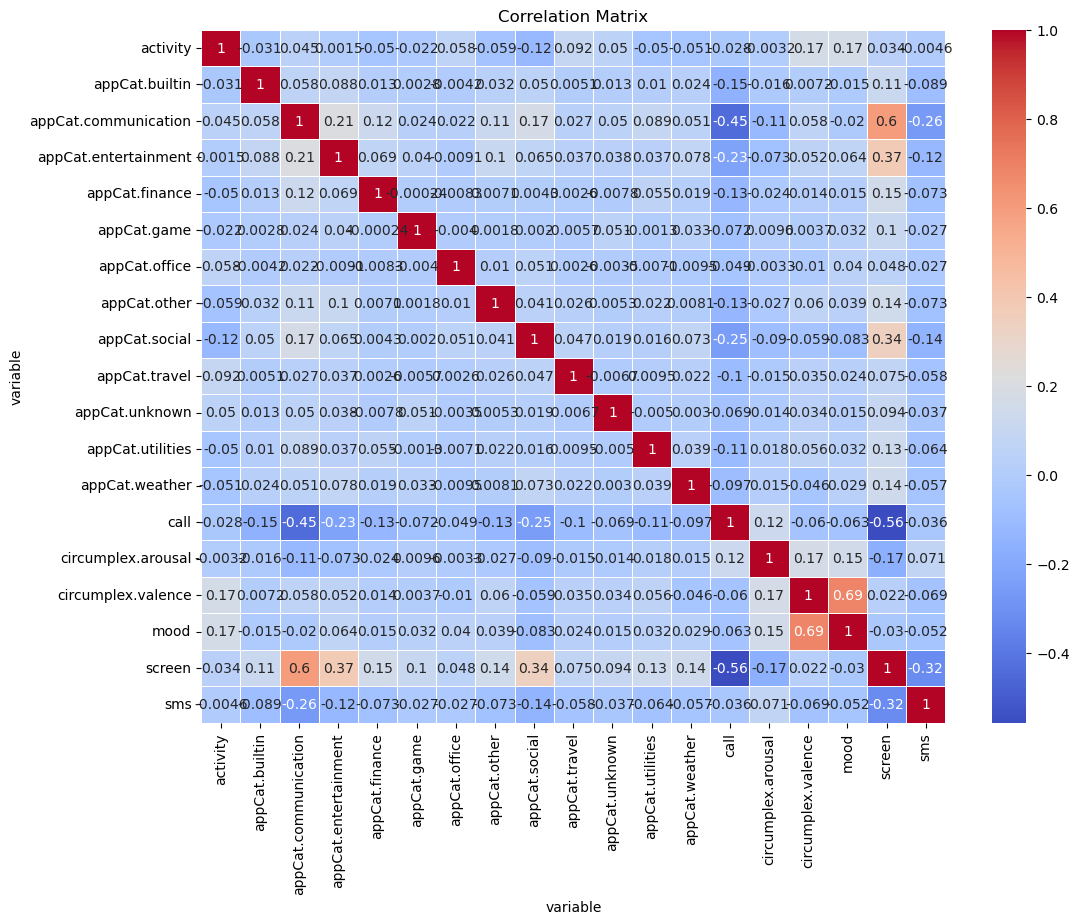

In [9]:
# correlation matrix of the aggregated variables
corr = grouped_wide.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [10]:
from itertools import cycle

palette = sns.color_palette("husl", n_colors=len(data.id.unique()))
color_cycle = cycle(palette)

for i in data.id.unique():
    current_color = next(color_cycle)
    plt.figure(figsize=(12, 6)) 
    sns.lineplot(
        data=data[data.id == i], 
        x='time', 
        y='mood', 
        color=current_color, 
        marker='o',  # Show data points as dots
        linestyle='--'  # Make the lines dashed
    )
    plt.title(i)
    plt.savefig('plots/timeseries/' + i + '.png')
    plt.clf()

/var/folders/cl/gr0w_0nd5b98g5nsjqhms9t40000gn/T/ipykernel_28491/522674978.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [11]:
# for every variable, plot the distribution
vars = ['mood']
for var in vars:
    if var not in ['id', 'time']:
        sns.histplot(data, x=var, kde=True)
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        # save plot
        plt.savefig('plots/distribution/' + var + '.png')
        plt.clf()

<Figure size 640x480 with 0 Axes>

## TASK 1C: FEATURE ENGINEERING

## Modelling

15:24:11 - cmdstanpy - INFO - Chain [1] start processing
15:24:11 - cmdstanpy - INFO - Chain [1] done processing


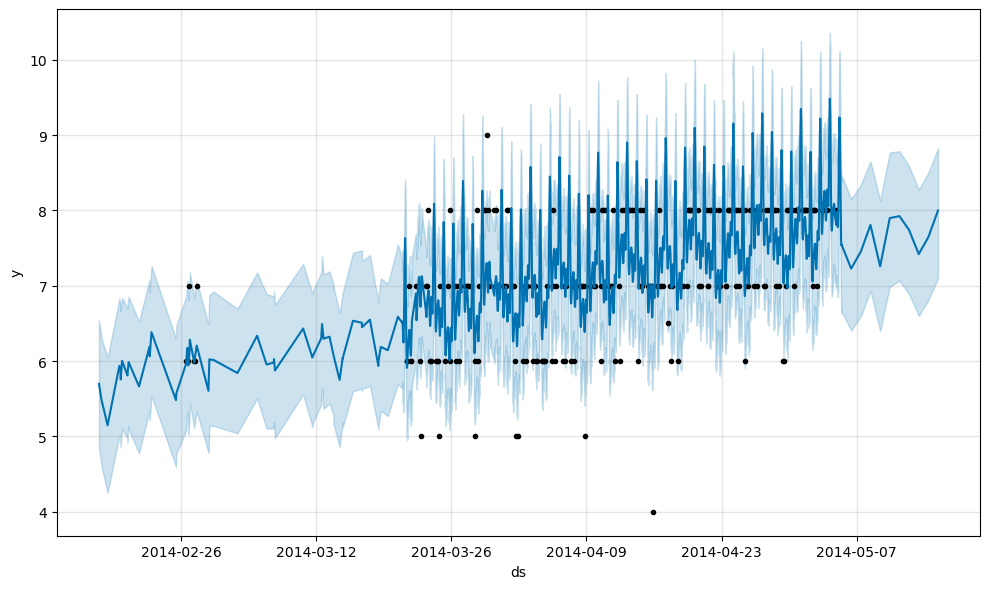

In [12]:
# select random id as data
df_prophet = data[data.id == 'AS14.01']

# Prepare the data
data['time'] = pd.to_datetime(data['time'])
df_prophet = df_prophet.rename(columns={'time': 'ds', 'mood': 'y'})

# Initialize the model
model = Prophet()

# Fit the model on the dataset
model.fit(df_prophet)

# Make future predictions
future = model.make_future_dataframe(periods=10)  # predict the next 'periods' days
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)